# AdaBoostV
The following class AdaBoostV implements AdaBoostV as described by [1] page 7. This algorithm deviates from the original AdaBoost [2] in two subtle ways

1. Computation of weights $\alpha_t$ of weak classifiers 
2. Final hypothesis have alphas normalized and does not use sign. 

The following code inherits from the AdaBoost class and implements only these minor changes. AdaBoostV is constructed identically to its superclass AdaBoost. See AdadBoost.ipynb for instructions. 

[1] http://www.jmlr.org/papers/volume6/ratsch05a/ratsch05a.pdf

In [5]:
%matplotlib notebook
import ipython_notebook_importer
import AdaBoost
from sklearn.tree import DecisionTreeClassifier
import sparsipy 
import numpy as np
import matplotlib.pyplot as plt
import copy

# Change style of plots
plt.style.use('ggplot')

class AdaBoostV(AdaBoost.AdaBoost):

    def __init__(self, visualize=False, print_progress = False, force_silent=False, color='g'):
        """Initialize stuff and save settings"""
       
        super().__init__(visualize=visualize, print_progress=print_progress, force_silent=force_silent, color='g')
        
        self.v               = None
        self.edges = []
            
    def fit(self, X, y, T, X_test=None, y_test=None):
        n, d = X.shape
        assert set(y) == {-1, +1}, ("Labels should be {-1, +1} and not ", set(y))
                
        # Approximation parameter, see [1]
        # TODO: Make sure setting it this way makes sense.
        self.v = np.sqrt(2*np.log(n) / T)

        if not X_test is None:
            self.test = True
            self.X_test = X_test
            self.y_test = y_test
        
        # start with uniform distribution and take T steps of AdaBoostV
        self.sample_weight = np.ones(n) / n 
        self.step_to(X, y, T)
        
    def step(self, X, y):
        """ Learn a single hypothesis and add it to ensemble. """
        # Make sure that sample weight is a distribution; sum to 1 and >=0. 
        assert np.allclose(np.sum(self.sample_weight), 1.0), np.sum(self.sample_weight)
        assert sum(self.sample_weight >= 0) == self.sample_weight.shape[0]
        
        # Learn weak DT classifier on weighed data weighed according to sample_weight
        h_t  = DecisionTreeClassifier(max_depth=1) # 1 => decision stump?
        h_t.fit(X, y, sample_weight=self.sample_weight)
        
        # Compute the edge of hypothesis h_t and add to list (step b in Algorithm 2)
        edge_t = np.sum( self.sample_weight * y * h_t.predict(X)) 
        self.edges.append(edge_t)
       
        # Find the minimal edge so far and compute current estimate 'rho_t' of optimal 
        # minimal margin (step d in Algorithm 2)
        edge_min = np.min(self.edges)
        rho_t = edge_min - self.v
        
        # Compute the weight for hypothesis h_t (step e in Algorithm 2)
        edge_part =  1/2 * np.log( (1+edge_t) / (1-edge_t) ) 
        rho_part  =  1/2 * np.log( (1+rho_t)  / (1-rho_t)  )
        alpha_t = edge_part - rho_part
    
        # Append estimator and weight to list. 
        self.estimators.append(h_t)
        self.alphas.append(alpha_t)

        # Update sample weight (step f in Algorithm 2)
        self.sample_weight = self.sample_weight * np.exp(- alpha_t * y * h_t.predict(X) )
        self.sample_weight = self.sample_weight / np.sum(self.sample_weight)
        
        # If DT perfectly classifies the weighed data set we are done (step c in Algorithm 3)
        # Moved to end because this is not really the case we are interested in. 
        if np.abs(edge_t) == 1.0: 
            #assert False, "Edge was 1.0, perfect classification, this actually happens?" 
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!PERFECT!!!!!!!!!!!!!!!!!!!!!!!")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            
        
    def predict(self, X):
        """ Returns the predicted labels for the given data. """
        n, d = X.shape
        
        # Predictions is similar to original AdaBoost, but unsigned with normalized weights (alpha). 
        pred = [self.alphas[t]*self.estimators[t].predict(X) for t in range(len(self.estimators))]
        pred = np.sum(pred, axis=0)
        
        assert pred.shape == (n, ), pred.shape
        return pred / np.sum(self.alphas)
    
    def margins(self, X, y):
        """ Compute margins. The margin of a data point x_i is defined as
        
            margin(x_i) := y_i * H(x) = y_i * sum_t alpha_t h_t(x) / sum_t alpha_t
        
        where the last part is just normalizing alphas. Notice predict takes care of 
        normalization so we do not have to do it here. 
        
        Parameters
        ----------
        X:     Matrix of size (n, d) with data point x_i as the i'th row. 
        y:     Array of size (n, ) with label y_i as the i'th entry. 
        
        Returns
        -------
        pred:  Array of size (n, ) where the i'th entry has the prediction of x_i. 
        """
        return y * self.predict(X)

    def minimal_margin(self, X, y):
        """ Returns the minimal margin. """
        return np.min(self.margins(X, y))
      
        
    def score(self, X, y):
        # compute 01 score; need to sign to do 01 loss.
        n, d = X.shape
        pred = np.sign(self.predict(X))
        return sum(pred == y) / n
    
        
    def __deepcopy__(self, memo):
        shallow_copy = super().__deepcopy__(memo)

        # override xs and minimal_margins
        shallow_copy.edges = []
        
        return shallow_copy

# Experiment: Sparsify (T=64)

Direct mm 500: 		 0.00307028681213
Direct E_test 500: 	 0.105


<IPython.core.display.Javascript object>


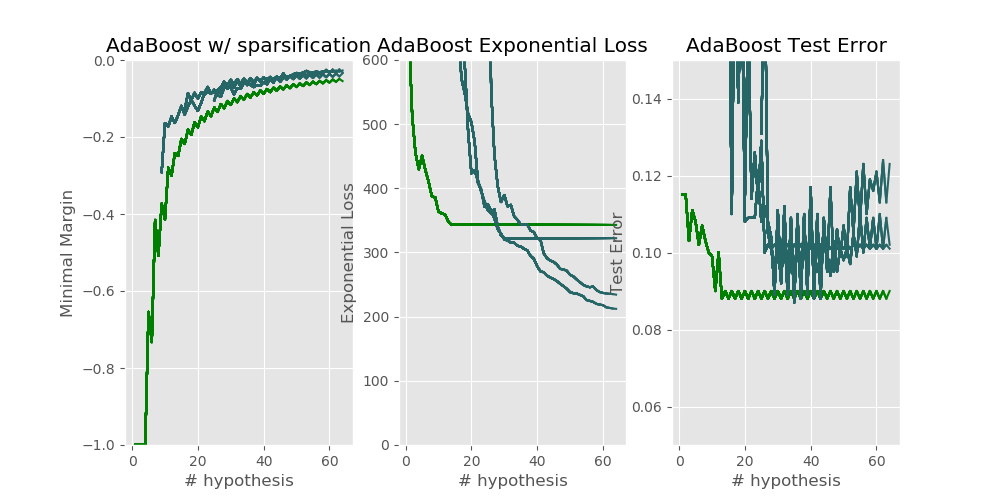

In [6]:
%matplotlib notebook
import ipython_notebook_importer
import DataSet as ds

# Get DataSet
data = ds.DataSet("generate", split=True)

# BaseLine
ada = AdaBoostV(visualize=False, force_silent=True)
ada.fit(data.X, data.y, 500)
print("Direct mm 500: \t\t", ada.minimal_margin(data.X, data.y))
print("Direct E_test 500: \t", ada.error(data.X_test, data.y_test))

# Sparsify on 64
T = 64

ada = AdaBoostV(visualize=True, force_silent=True)

ada.ylim_mm = [-1.0, 0]
ada.ylim_exploss = [0, 600]
ada.ylim_test_error = [0.05, 0.15]

ada.fit(data.X, data.y, T, X_test=data.X_test, y_test=data.y_test)
ada.sparsify(data.X, data.y, 10)

# Experiment: Retrain (T=64)

Direct mm 1000: 	 -0.00376566175096
Direct E_test 1000: 	 0.099


<IPython.core.display.Javascript object>


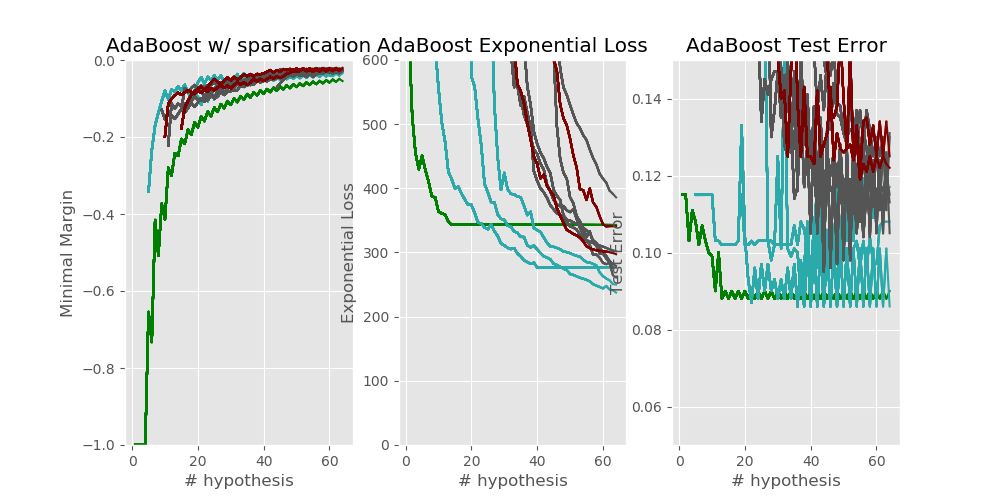

In [ ]:
%matplotlib notebook
import ipython_notebook_importer
import DataSet as ds

# Get DataSet
data = ds.DataSet("generate", split=True)

# BaseLine
ada = AdaBoostV(visualize=False, print_progress=False)
ada.fit(data.X, data.y, 1000)
print("Direct mm 1000: \t", ada.minimal_margin(data.X, data.y))
print("Direct E_test 1000: \t", ada.error(data.X_test, data.y_test))

# Retrain 64
T = 64

ada = AdaBoostV(visualize=True, force_silent=True)

ada.ylim_mm = [-1.0, 0]
ada.ylim_exploss = [0, 600]
ada.ylim_test_error = [0.05, 0.15]

ada.retrain(data.X, data.y, repeat=3, max=T, X_test =data.X_test, y_test=data.y_test)